# pip installs

In [24]:
%pip install cmake

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
%pip install dlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
%pip install opencv-python face-recognition

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
%pip install scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
%pip install albumentations

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip uninstall opencv-python-headless -y 
!pip install opencv-python --upgrade

# Imports

In [2]:
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [3]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import face_recognition
import matplotlib.pyplot as plt
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomRotate90, Transpose, 
    RandomBrightnessContrast, ShiftScaleRotate, Blur, CLAHE, 
    HueSaturationValue, CoarseDropout, GaussianBlur, OneOf, Compose
)

# Utils

In [4]:
path_data = "D:/GitHub/101MachineLearning/000_data/master/percepcion_computacional/caso2"

In [5]:
def extract_face_from_image(image, target_size=(224, 224)):
    img = None
    face_location = face_recognition.face_locations(image)
    if face_location:
        top, right, bottom, left = face_location[0]
        face_image = image[top:bottom, left:right]
        face_image = cv2.resize(face_image, target_size)
        img = np.array(face_image)
    return img


def process_image(image_path, target_size, create_encodings=False, extract_face=True, normalize=True):
    if create_encodings:
        # 128 feature vector para cada imagen
        if isinstance(image_path, str):
            image = face_recognition.load_image_file(image_path)
        else:
            image = image_path
        face_encodings = face_recognition.face_encodings(image)
        if face_encodings:
            return face_encodings[0]
    else:
        
        if isinstance(image_path, str):
            image_original = cv2.imread(image_path)
        else:
            image_original = image_path

        if image_original is not None:
            image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
            if extract_face:
                # Puede extraer una matriz de zeros si no hay una imagen
                image_face = extract_face_from_image(image_original, target_size)
                if image_face is None:
                    image = cv2.resize(image_original, target_size)
                    image = np.array(image)
                else:
                    image = image_face
            else:
                image = cv2.resize(image, target_size)
                image = np.array(image)

            if normalize:
                image = image / 255.0

            # image = np.expand_dims(image, axis=0)
            return image
    return None


# Función para cargar imágenes y etiquetas
def load_images(dataset_path, create_encodings=False, target_size=(224, 224), extract_face=False, num_data_augmentation=0):
    X = []
    y = []
    for person_name in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person_name)
        if os.path.isdir(person_folder):
            for image_name in os.listdir(person_folder):
                image_path = os.path.join(person_folder, image_name)

                image = process_image(image_path, target_size, create_encodings, extract_face, normalize=False)

                """
                HorizontalFlip(p=0.5): Crea una imagen reflejada horizontalmente, útil para simular variaciones de posición en los datos.
                VerticalFlip(p=0.5): Crea una imagen reflejada verticalmente, aunque esto puede ser menos comúnmente útil para ciertos tipos de datos (e.g., caras).
                RandomRotate90(p=0.5): Rota la imagen en incrementos de 90 grados, útil para datos que no dependen de la orientación específica.
                Transpose(p=0.5): Crea una imagen que es una transposición de la original, cambiando la orientación.
                ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5): Aplica una combinación de traslación (shift), escalado (scale), y rotación (rotate) a la imagen.
                
                OneOf: Aplica una de las transformaciones especificadas en la lista, con la probabilidad combinada definida en p para cada una de ellas.
                RandomBrightnessContrast(p=0.5): Ajusta aleatoriamente el brillo y el contraste de la imagen.
                CLAHE(p=0.5): Aplica la técnica de ecualización de histograma adaptativa con contraste limitado.
                HueSaturationValue(p=0.5): Ajusta aleatoriamente el tono (hue), la saturación y el valor de la imagen.

                OneOf: Aplica una de las transformaciones especificadas en la lista, con la probabilidad combinada definida en p para cada una de ellas.
                Blur(p=0.5): Aplica un desenfoque a la imagen.
                GaussianBlur(p=0.5): Aplica un desenfoque gaussiano a la imagen.

                CoarseDropout(p=0.5): Introduce áreas faltantes en la imagen, lo cual puede hacer al modelo más robusto frente a occlusiones o daños en la imagen.
                """

                transform = Compose([
                    HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.5),
                    RandomRotate90(p=0.5),
                    Transpose(p=0.5),
                    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
                    OneOf([
                        RandomBrightnessContrast(p=0.5),
                        CLAHE(p=0.5),
                        HueSaturationValue(p=0.5),
                    ], p=1),
                    OneOf([
                        Blur(p=0.5),
                        GaussianBlur(p=0.5),
                    ], p=1),
                    CoarseDropout(p=0.5)
                ])

                if image is not None:
                    X.append(image / 255.0)
                    y.append(person_name)

                    if image.dtype != np.uint8:
                        image = image.astype(np.uint8)
                    for _ in range(num_data_augmentation):

                        augmented = transform(image=image)['image']
                        
                        X.append(augmented / 255.0)
                        y.append(person_name)
                            
    return np.array(X), np.array(y)

In [6]:
def label_inverse_transform(label_encoder, predicts):
    if not isinstance(predicts, list):
        predicts = [predicts]
    return list(label_encoder.inverse_transform(predicts))

def predict_category(img, model, label_encoder):
    pred = model.predict(np.expand_dims(img, axis=0))
    category = label_inverse_transform(label_encoder, np.argmax(pred, axis=1))[0]
    return category

def draw_label_on_image(model, image_path, label_encoder, extract_face=False):
    # Leer la imagen
    img = process_image(image_path, (224, 224), False, extract_face=extract_face, normalize=True)
    category = predict_category(img, model, label_encoder)
    # Definir la posición de la caja de texto
    height, width, _ = img.shape
    box_height = 30
    y0, dy = height - box_height, box_height - 5
    
    # Dibujar una caja en la parte baja de la imagen
    cv2.rectangle(img, (0, height - box_height), (width, height), (0, 0, 0), -1)
    
    # Configurar el texto a mostrar
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    color = (255, 255, 255)  # Blanco
    thickness = 2
    
    # Poner el texto en la imagen
    cv2.putText(img, category, (10, height - 10), font, font_scale, color, thickness)
    
    # Mostrar la imagen resultante
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = np.argmax(self.model.predict(val_data), axis=1)
        f1 = f1_score(val_labels, val_pred, average='weighted')
        print(f' — val_f1_score: {f1:.4f}')

# Carga de imágenes para CASO 2

In [36]:
# Cargar las imágenes y etiquetas: Puede procesar la cara como feature vector para facilitar nuevo entrenamiento
# o extraerla en imagen para
X, y = load_images(path_data, create_encodings=False, target_size=(224, 224), extract_face=True, num_data_augmentation=5)

# Codificar las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=64)

In [37]:
import pickle
with open("./output/y.pickle", "wb") as f_out:
    pickle.dump(y, f_out)

In [38]:
# Data Augmentation: Rotar imágenes, poner cuadros, cambiar brillo, etc
print(X_train.shape, X_train[0].shape)
print(X_test.shape, X_test[0].shape)

(1003, 224, 224, 3) (224, 224, 3)
(251, 224, 224, 3) (224, 224, 3)


In [39]:
EPOCHS = 20
BATCH_SIZE = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Instanciar el callback F1ScoreCallback
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))

# Crear el modelo base usando MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas de clasificación
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Para controlar overfitting
predictions = Dense(len(np.unique(y_encoded)), activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo: sparse porque no uso one-hot-encoding para ahorrar espacio, pero esto lo maneja internamente
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Instanciar el callback F1ScoreCallback
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))

# Entrenar el modelo
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), callbacks=[f1_callback, early_stopping])

# Predecir las etiquetas y las probabilidades
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular el F1-score para tener un entendimiento más exacto
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1-Score: {f1 * 100:.2f}')

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/stepep - accuracy: 0.6851
 — val_f1_score: 0.9364
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.6892 - loss: 0.9152 - val_accuracy: 0.9363 - val_loss: 0.1550
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/stepep - accuracy: 0.969
 — val_f1_score: 0.9682
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.9696 - loss: 0.0894 - val_accuracy: 0.9681 - val_loss: 0.1079
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/stepep - accuracy: 0.971
 — val_f1_score: 0.9564
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.9711 - loss: 0.0823 - val_accuracy: 0.9562 - val_loss: 0.1642
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/stepep - accuracy: 0.957
 — val_f1_score: 0.9800
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - accuracy: 0.9585 - loss: 0.0845 - val_accuracy: 0.9801 - val_loss: 0.0919
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/stepep - accuracy: 0.995
 — val_f1_score: 0.9722
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.9

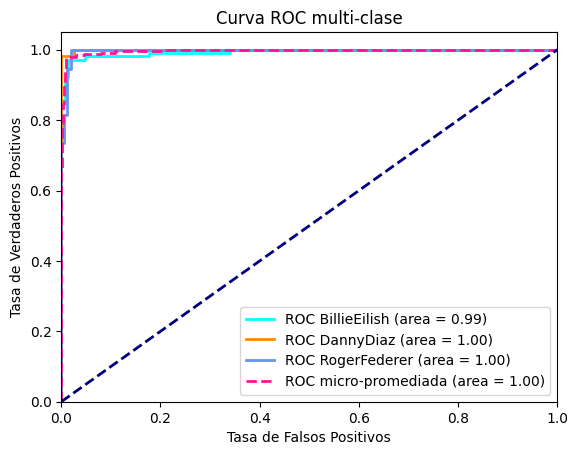

In [40]:
from sklearn.preprocessing import label_binarize

n_classes = len(np.unique(y_test))

# Binarizar las etiquetas para el cálculo de ROC
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC micro-promediada y el AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotear la curva ROC para cada clase y la micro-promediada
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple']
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        color=colors[i % len(colors)],
        lw=2, label='ROC {0} (area = {1:0.2f})'.format(label_inverse_transform(label_encoder, i)[0], roc_auc[i])
    )

plt.plot(
    fpr["micro"], tpr["micro"], color='deeppink', linestyle='--',
    lw=2, label='ROC micro-promediada (area = {0:0.2f})'.format(roc_auc["micro"])
)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC multi-clase')
plt.legend(loc="lower right")
plt.show()

# Test: Imágenes que no ha visto el algoritmo y no están en validación

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\usuario\anaconda3\envs\env_ai\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


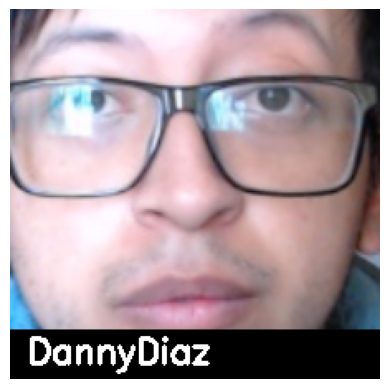

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\usuario\anaconda3\envs\env_ai\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


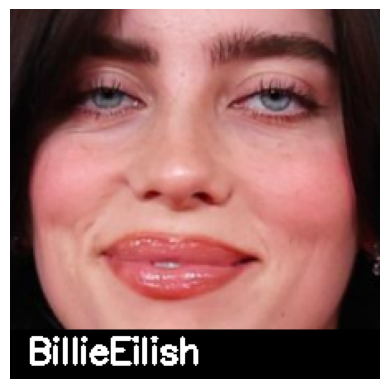

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


c:\Users\usuario\anaconda3\envs\env_ai\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


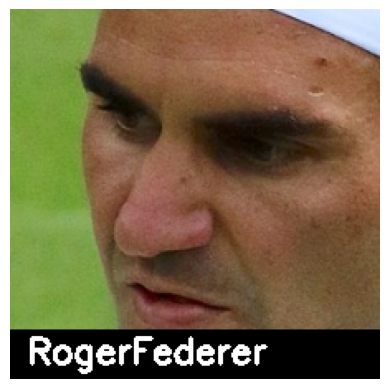

In [41]:
draw_label_on_image(model, f"{path_data}/../test/mi_rostro_2.jpg", label_encoder, extract_face=True)
draw_label_on_image(model, f"{path_data}/../test/billie.jpg", label_encoder, extract_face=True)
draw_label_on_image(model, f"{path_data}/../test/roger.jpg", label_encoder, extract_face=True)

In [42]:
# Guardar y evaluar el modelo
model_path = './models/face_recognition_model.h5'
model.save(model_path)

# Caso 2: Reconocimiento de caras en tiempo real

In [9]:
from tensorflow.keras.models import load_model
model_path = './models/face_recognition_model.h5'
model_loaded = load_model(model_path)

In [10]:
import pickle
with open("./output/y.pickle", "rb") as f_out:
    yt = pickle.load(f_out)
    label_encoder = LabelEncoder()
    label_encoder.fit_transform(yt.ravel())

    # Test
    print(label_inverse_transform(label_encoder, [0, 1, 2]))

['BillieEilish', 'DannyDiaz', 'RogerFederer']


In [11]:
from datetime import datetime, timedelta
import warnings
from sklearn.exceptions import DataConversionWarning

# Suprimir específicamente DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Iniciar la captura de video
cap = cv2.VideoCapture(0)  # 0 para la cámara web predeterminada

while True:
    # Leer un frame del video
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir el frame a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Usar un clasificador de Haar para detectar rostros
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        # Extraer la región de interés (ROI) de la cara
        face = process_image(face, (224, 224), create_encodings=False, extract_face=True, normalize=True) # frame[y:y+h, x:x+w]
        
        # Preprocesar la imagen de la cara
        class_label = predict_category(face, model_loaded, label_encoder)

        now = datetime.now()
        # Dibujar una caja alrededor de la cara
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, class_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Ordenar la asistencia por la hora en orden descendente
    # Mostrar el frame con las cajas y etiquetas
    cv2.imshow('Video', frame)

    # Salir del bucle si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar el objeto de captura y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

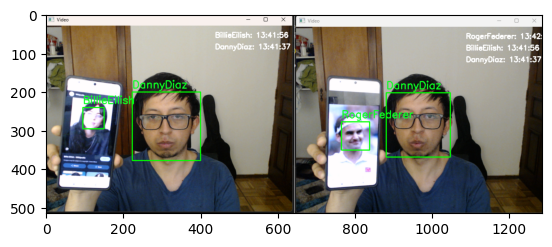

In [15]:
# Solo si la cara aparece por 2 segundos consecutivos se registra la asistencia en la parte superior derecha (acepta intermitencias!)
plt.imshow(cv2.cvtColor(cv2.imread(f"../input/resultados.png"), cv2.COLOR_BGR2RGB))